In [2]:
import argparse
import os

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

import jax
from jax.experimental.ode import build_odeint
import jax.numpy as np
from jax.random import PRNGKey
from jax import lax

import numpyro
import numpyro.distributions as dist
from numpyro.examples.datasets import LYNXHARE, load_dataset
from numpyro.infer import MCMC, NUTS, Predictive

import pandas as pd

## Deterministic model

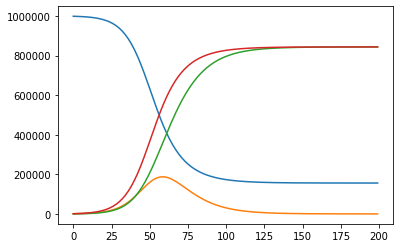

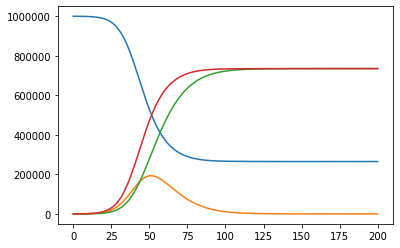

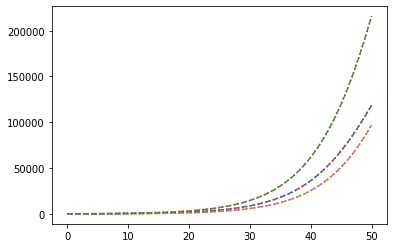

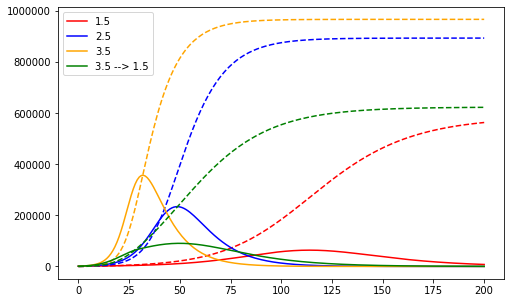

In [3]:
def dx_dt(x, t, beta, gamma):
    """
    SIR equations. Real positive parameters `beta`, `gamma`,
    describe the infection rate and recovery rate.
    Also tracks new infections.
    """
    S = x[0]
    I = x[1]
    R = x[2]
    n = S + I + R
    I_tot = x[3]
    dS_dt = - beta * S * I / n
    dI_dt = beta * S * I / n - gamma * I
    dR_dt = gamma * I
    dItot_dt = beta * S * I / n
    return np.stack([dS_dt, dI_dt, dR_dt, dItot_dt])

SIR_int = build_odeint(dx_dt, rtol=1e-5, atol=1e-3, mxstep=500)


# Run from 0 to T-1 inclusive (T time steps)
def SIR_deterministic(T, beta=2.2/10, gamma=1.0/10, N=1e6, I_init=0.001):
    x_init = N*np.array([1-I_init, I_init, 0, I_init])
    ts = np.arange(T, dtype='float32')
    X = SIR_int(x_init, ts, beta, gamma)
    return X

def SIR_time_varying(T, beta=2.2/10, gamma=1.0/10, N=1e6, I_init=0.001):
    
    # beta, gamma describe transitions: so have length T-1
    beta = np.broadcast_to(beta, (T-1,))
    gamma = np.broadcast_to(gamma, (T-1,))  
    
    x_init = N*np.array([1-I_init, I_init, 0, I_init])

    t_one_step = np.array([0.0, 1.0])
    def advance(x, theta):
        x_new = SIR_int(x, t_one_step, *theta)[1]
        return x_new, x_new

    # Run T–1 steps of the dynamics starting from the intial distribution
    _, X = lax.scan(advance, x_init, (beta, gamma), T - 1)
    return np.vstack((x_init, X))


ramp = np.linspace
def extend(x, T):
    t = len(x)
    return x if t >= T else np.hstack((x, x[-1]*np.ones(T-t)))

def test_SIR_deterministic():
    T = 200
    gamma = 1.0/10.0
    beta = 2.2 * gamma
    X = SIR_deterministic(T, beta, gamma)
    plt.plot(X)
    plt.show()

def test_SIR_time_varying():
    
    T = 201
    beta0 = 3.5/10.0
    beta1 = 0.5/10.0
    beta = extend(ramp(beta0, beta1, 100), T-1)

    gamma = 1.0/10.0
    N = 1e6
    I_init = 0.0001

    X = SIR_time_varying(T, beta, gamma, N=N, I_init=I_init)
    plt.plot(X)
    plt.show()

def compare_SIR_dynamics():
    # compare to see if dynamics are (nearly) the same when time-varying
    # function is used by parameters do not vary with time
    
    T = 51
    beta = 2.5/10.0
    gamma = 1.0/10.0
    N = 1e6
    I_init = 0.0001

    X1 = SIR_deterministic(T, beta, gamma, N=N, I_init=I_init)
    X2 = SIR_time_varying(T, beta, gamma, N=N, I_init=I_init)

    plt.plot(X1[:,1:], linestyle='--')
    plt.plot(X2[:,1:], linestyle=':')
    plt.show()

    
def compare_SIR():
    
    # look at the qualitative difference between model with constant
    # dynamics and time-varying dynamics
    
    T = 201
    gamma = 1/10
    
    R0_vals = [1.5, 2.5, 3.5]
    colors = ['r', 'b', 'orange']

    plt.figure(figsize=(8,5))
    for R0, color in zip(R0_vals, colors):
        beta = R0*gamma
        x = SIR_deterministic(T, beta=beta, gamma=gamma, N=1e6)
        plt.plot(x[:,1], color=color, linestyle='-')
        plt.plot(x[:,2], color=color, linestyle='--')
        

    # Test time-varying dynamics
    R0 = extend(ramp(3.5, 1.5, 30), T-1)
    beta = R0 * gamma
    x = SIR_time_varying(T, beta=beta, gamma=gamma, N=1e6)
    plt.plot(x[:,1], color='g', linestyle='-')
    plt.plot(x[:,2], color='g', linestyle='--')
    
    plt.legend(plt.gca().lines[::2], R0_vals + ['3.5 --> 1.5'])
    plt.show()

run_tests = True

if run_tests:
    test_SIR_deterministic()
    test_SIR_time_varying()
    compare_SIR_dynamics()
    compare_SIR()

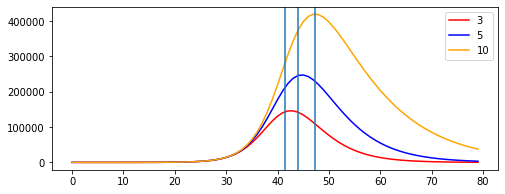

In [111]:
def fixed_growth_rate():

    # Compare SIR curves with same growth rate but different gamma
    T = 80
    offset = 0.32
    
    durations = [3, 5, 10]
    colors = ['r', 'b', 'orange']

    N = 1e6
    I_init = 1/N

    lines = []
    plt.figure(figsize=(8,3))
        
    for duration, color in zip(durations, colors):
        
        gamma = 1./duration
        beta = gamma + offset
        
        X = SIR_deterministic(T, beta, gamma, N=N, I_init=I_init)
        lines += plt.plot(X[:,1], linestyle='-', color=color)
        #plt.plot(X[:,2], linestyle='--', color=color)
        plt.plot()
    
    plt.legend(lines, durations)

    for c in [0.1, 0.2, 0.5]:
        peak_heuristic = (np.log(c) + np.log(N))/np.log(1.32)
        plt.axvline(peak_heuristic)

fixed_growth_rate()

## Current model: SIR model for new cases with random parameters/observations, deterministic dynamics

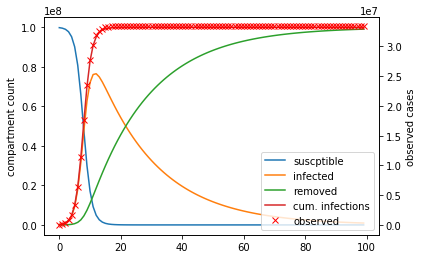

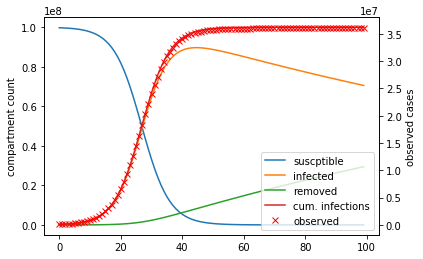

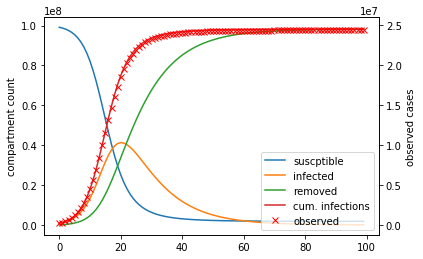

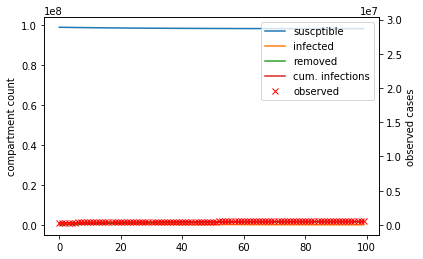

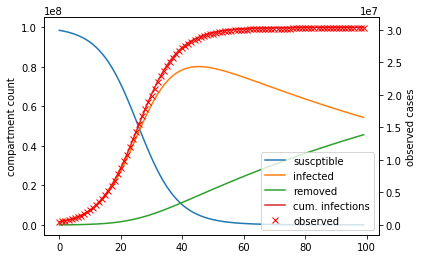

In [242]:
def SIR_hybrid(T = 50, 
               N = 1e5, 
               duration_mean = 10,
               R0_mean = 2.2,
               gamma_shape = 1,
               beta_shape = 1,
               det_rate_mean = 0.3,
               det_rate_conc = 50,
               det_conc = 1000,
               confirmed = None,
               obs_type = 'new'):

    # Sample initial fraction of infected individuals
    I_init = numpyro.sample("I_init", dist.Uniform(0, 0.02))

    # Sample parameters
    gamma = numpyro.sample("gamma", 
                           dist.Gamma(gamma_shape, gamma_shape * duration_mean))
    
    beta = numpyro.sample("beta", 
                          dist.Gamma(beta_shape, beta_shape * duration_mean/R0_mean))

    det_rate = numpyro.sample("det_rate", 
                              dist.Beta(det_rate_mean * det_rate_conc,
                                        (1-det_rate_mean) * det_rate_conc))

    # Run simultation using ODE solve
    x_init = N * np.array([1-I_init, I_init, 0.0, I_init])
    t = np.arange(T, dtype='float32')
    x = SIR_int(x_init, t, beta, gamma)
    numpyro.deterministic("x", x)
    

    if obs_type == 'total':
        # Compute number of new infections in each time step
        latent = x[:,3]   # total number infected

        # Generate noisy observations as latent * Beta(alpha, beta)
        alpha = det_rate * det_conc * np.ones(T)
        beta = (1-det_rate) * det_conc * np.ones(T)

        d = dist.TransformedDistribution(dist.Beta(alpha, beta),
                                         dist.transforms.AffineTransform(0, scale=latent))

        if confirmed is None:
            mask = np.zeros(T, dtype='bool')
        else:
            mask = confirmed > 0
        
        with numpyro.handlers.mask(mask):
            y = numpyro.sample("y", d, obs = confirmed)
    
    
    elif obs_type == 'new':
        
        latent = np.diff(x[:,3])
        latent = np.hstack((x_init[3], latent))

        # Generate noisy observations as latent * Beta(alpha, beta)
        alpha = det_rate * det_conc * np.ones(T)
        beta = (1-det_rate) * det_conc * np.ones(T)

        d = dist.TransformedDistribution(dist.Beta(alpha, beta),
                                         dist.transforms.AffineTransform(0, scale=latent))

        if confirmed is None:
            new_confirmed = None
            mask = np.zeros(T, dtype='bool')
        else:
            new_confirmed = np.diff(confirmed)
            new_confirmed = np.hstack((confirmed[0], new_confirmed))
            mask = (np.arange(T) > 0) & (new_confirmed > 1) # model has hard time with small observations?
        
        with numpyro.handlers.mask(mask):
            new = numpyro.sample("y", d, obs = new_confirmed)
            y = np.cumsum(new)
            
    return x, y, det_rate

def test_hybrid(i, log_scale=False, **kwargs):
    with numpyro.handlers.seed(rng_seed=i):
        x, y, obs_rate = SIR_hybrid(**kwargs)

    T = len(x)
    ts = np.arange(T)
    
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    
    l1 = ax1.plot(ts, x)    
    l2 = ax2.plot(ts, y, 'x', color='r')
        
    plt.legend(l1 + l2, ['suscptible', 'infected', 'removed', 'cum. infections', 'observed'])
    
    ax1.set_ylabel('compartment count')
    ax2.set_ylabel('observed cases')

    if log_scale:
        ax1.set_yscale('log')
        ax2.set_yscale('log')
    
    ylim = np.array(ax1.get_ylim())
    ax2.set_ylim(obs_rate * ylim )
    
    plt.show()

for i in range(5):
    test_hybrid(i, log_scale=False, T=100, N=1e8)

In [214]:
def plot_samples(samples, plot_fields=['I', 'y'], obs_type='total', T=None, t=None, ax=None):
    
    T_data = samples['x'].shape[1] - 1
    if T is None or T > T_data:
        T = T_data

    X = samples['x']
    
    labels = {
        'S': 'susceptible',
        'I': 'infected',
        'R': 'removed',
        'C': 'confirmed'
    }
    
    fields = {'S': X[:,:T,0],
              'I': X[:,:T,1],
              'R': X[:,:T,2],
              'C': X[:,:T,3]}    
    
    if 'y' in samples:
        if obs_type == 'new':
            fields['y'] = np.cumsum(samples['y'][:,:T], axis=1)
        elif obs_type == 'total':
            fields['y'] = samples['y'][:,:T]
    
    fields = {k: fields[k] for k in plot_fields}

    means = {k: v.mean(axis=0) for k, v in fields.items()}
    
    pred_intervals = {k: np.percentile(v, (10, 90), axis=0) for k, v in fields.items()}
    
    # Use pandas to plot means (for better date handling)
    if t is None:
        t = np.arange(T)        

    df = pd.DataFrame(index=t, data=means)
    df.plot(ax=ax)
    
    # Add prediction intervals
    for k, pred_interval in pred_intervals.items():
        ax = ax if ax is not None else plt.gca()
        ax.fill_between(t, pred_interval[0,:], pred_interval[1,:], alpha=0.1)

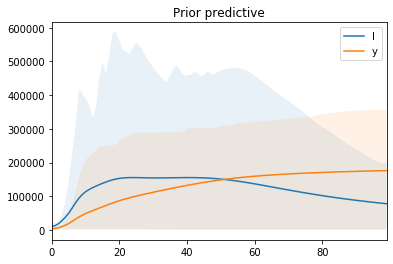

In [174]:
T = 200
N = 1e6
obs_type = 'new'
predictive = Predictive(SIR_hybrid, 
                        posterior_samples = {}, 
                        num_samples=100)

samples = predictive(PRNGKey(2), T=T, N=N)

plot_samples(samples, T=100, obs_type=obs_type)
plt.title('Prior predictive')
plt.show()

In [245]:
import jhu

world = jhu.load_world()
US = jhu.load_us()

pop = {
    'Italy': 60.48e6,
    'US': 3.27e8,
    'MA': 6.902e6,
    'WA': 7.536e6,
    'NY': 19.54e6
}

data = {
    'Italy': world['Italy']['tot'],
    'US': US['tot']
}

# Add all US state
data = dict(data, **{k[0]: US[k[0]] for k in US.columns})

place = 'US'

start = pd.Timestamp('2020-03-01')

confirmed = data[place].confirmed[start:]
T = len(confirmed)
N = pop[place]

kernel = NUTS(SIR_hybrid)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000, num_chains=1)

init = {
    'I_init': 0.01,
    'gamma': 1/10.0,
    'beta': 2.5/10.0,
    'det_rate' : 0.3
}


obs_type = 'new'
det_conc = 100 if obs_type == 'new' else 1000

mcmc.run(jax.random.PRNGKey(2), 
         N=N, 
         T=T, 
         confirmed=confirmed.values,
         obs_type = 'total',
         det_conc=det_conc,
         gamma_shape = 10,
         init_params=init)
mcmc.print_summary()
mcmc_samples = mcmc.get_samples()

sample: 100%|██████████| 3000/3000 [00:46<00:00, 64.04it/s, 7 steps of size 5.41e-02. acc. prob=0.92]   



                mean       std    median      5.0%     95.0%     n_eff     r_hat
    I_init      0.00      0.00      0.00      0.00      0.00    452.26      1.01
      beta      0.43      0.03      0.42      0.37      0.47    580.71      1.00
  det_rate      0.37      0.06      0.37      0.28      0.46    517.68      1.00
     gamma      0.12      0.03      0.11      0.07      0.18    585.84      1.00

Number of divergences: 4


In [246]:
# Visualize posterior predictive samples
T = 200
post_pred = Predictive(SIR_hybrid, posterior_samples = mcmc_samples)
post_pred_samples = post_pred(PRNGKey(2), T=T, N=N)

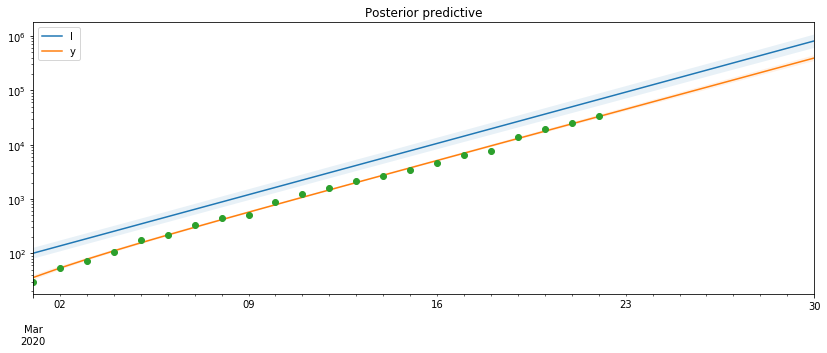

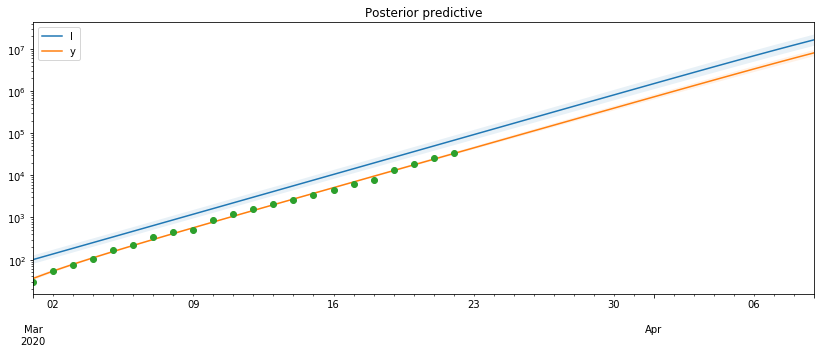

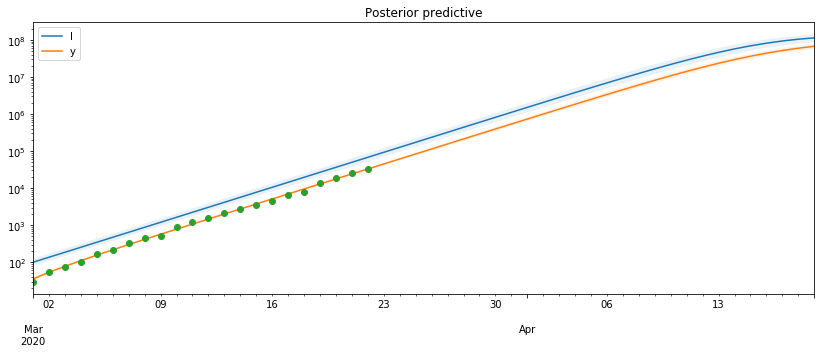

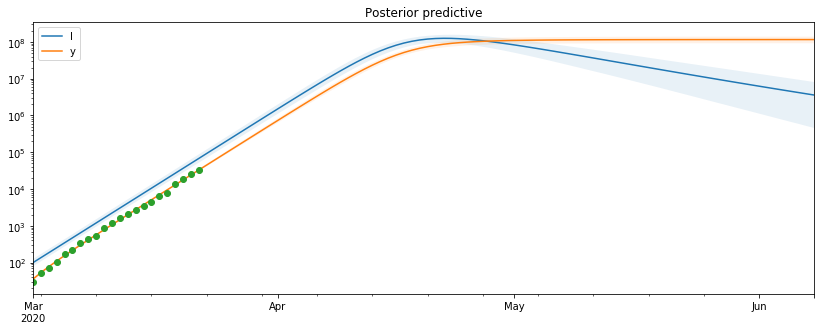

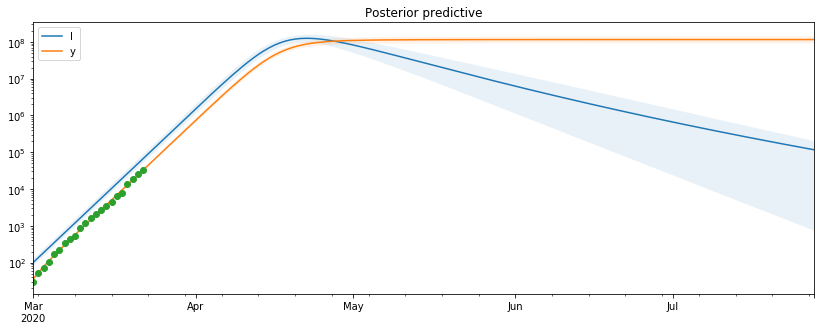

In [247]:
scale = 'log'

for T in [30, 40, 50, 100, 150]:
    
    t = pd.date_range(start=start, periods=T, freq='D')
    
    fig, ax = plt.subplots(figsize=(14,5))
    plot_samples(post_pred_samples, T=T, t=t, ax=ax, obs_type=obs_type, plot_fields=['I', 'y'])
    plt.title('Posterior predictive')
    
    confirmed.plot(style='o')
    
    if scale == 'log':
        plt.yscale('log')
        
    filename = f'figs/{place}_predictive_scale_{scale}_T_{T}.pdf'
    plt.savefig(filename)
    plt.show()
    

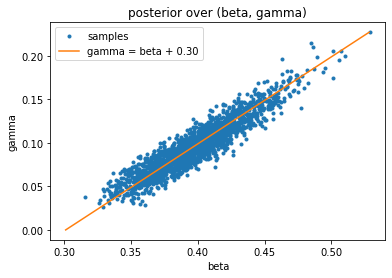

R0: 4.5235133


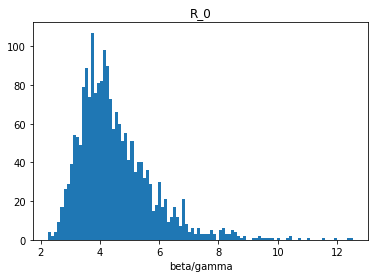

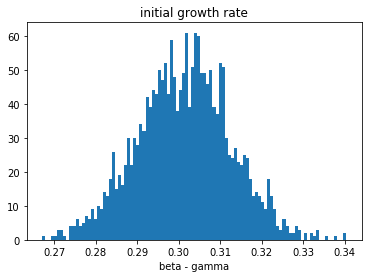

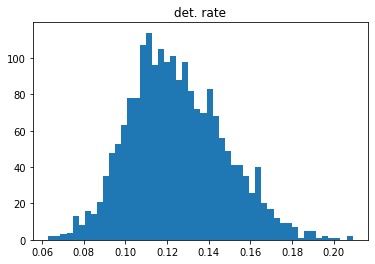

In [232]:
save = True

beta = mcmc_samples['beta']
gamma = mcmc_samples['gamma']
plt.plot(beta, gamma, '.')
offset = (beta-gamma).mean()

plt.plot([0.+offset, gamma.max()+offset], [0., gamma.max()])
plt.xlabel('beta')
plt.ylabel('gamma')
plt.title('posterior over (beta, gamma)')
plt.legend(['samples', r'gamma = beta + ' + f'{offset:.2f}'])
if save:
    filename = f'figs/{place}_beta_gamma.pdf'
    plt.savefig(filename)
plt.show()


plt.hist(beta/gamma, bins=100)
plt.title('R_0')
plt.xlabel('beta/gamma')
R_0_mean = np.mean(beta/gamma)
print("R0:", R_0_mean)
if save:
    filename = f'figs/{place}_R0.pdf'
    plt.savefig(filename)
plt.show()


growth_rate = mcmc_samples['beta'] - mcmc_samples['gamma']
plt.hist(growth_rate, bins=100)
plt.title('initial growth rate')
plt.xlabel('beta - gamma')
if save:
    filename = f'figs/{place}_growth_rate.pdf'
    plt.savefig(filename)
plt.show()

plt.hist(mcmc_samples['det_rate'], bins=50)
plt.title('det. rate')
if save:
    filename = f'figs/{place}_growth_rate.pdf'
    plt.savefig(filename)
plt.show()


## Simples routines for covidtracking.com data

Now using jhu data, but consider keeping this around for comparison

In [ ]:
def load_us():
    df = pd.read_csv('us-daily.csv')
    df.date = pd.to_datetime(df.date, format='%Y%m%d')
    df = df.set_index('date')
    df = df.sort_index()
    return df.positive

def load_state(state='MA'):
    df = pd.read_csv('states-daily.csv')
    df.date = pd.to_datetime(df.date, format='%Y%m%d')
    df = df.set_index('date')
    df = df.sort_index()
    return df[df.state==state].positive.sort_index()

## Old: stochastic dynamics

In [ ]:
def SIR_stochastic(dt = 1.0, 
                   steps = 50,
                   N = 1e5,
                   I_frac=0.05,
                   duration_mean=10,
                   duration_scale_factor=0.5,
                   R0_mean=2.2,
                   R0_scale_factor=0.2,
                   obs_rate=0.3,
                   obs_conc=50,
                   SI_conc=50,
                   IR_conc=50,
                   dynamics="Beta"):
    
    x_init = N*np.array([1-I_frac, I_frac, 0])
    N = x_init.sum()
    
    duration = numpyro.sample(
        "duration", 
        dist.TruncatedNormal(low=0.,
                             loc=duration_mean, 
                             scale=duration_mean*duration_scale_factor))
    
    R0 = numpyro.sample("R0",
                        dist.TruncatedNormal(low=0.,
                                             loc=R0_mean,
                                             scale=R0_scale_factor))
    
    gamma = 1./duration    
    beta = R0 * gamma
    
    numpyro.deterministic("beta", beta)
    numpyro.deterministic("gamma", gamma)
        
    j = 0
    def advance(x, ignore):
        nonlocal j

        S, I, R = x
        
        rate_SI = beta * I / N
        rate_IR = gamma

        p_SI = 1 - np.exp(-rate_SI * dt)
        p_IR = 1 - np.exp(-rate_IR * dt)
                

        if dynamics=="Binomial":
            n_SI = numpyro.sample(f'n_SI_{j}', dist.Binomial(S, p_SI))
            n_IR = numpyro.sample(f'n_IR_{j}', dist.Binomial(I, p_IR))
        
        elif dynamics=="Beta":
            n_SI = S * numpyro.sample(f'n_SI_{j}', dist.Beta(p_SI * SI_conc, 
                                                             (1-p_SI) * SI_conc))
            n_IR = I * numpyro.sample(f'n_IR_{j}', dist.Beta(p_IR * SI_conc, 
                                                             (1-p_IR) * IR_conc))

        elif dynamics=="Poisson":
            n_SI = numpyro.sample(f'n_SI_{j}', dist.Poisson(S * rate_SI * dt))
            n_IR = numpyro.sample(f'n_IR_{j}', dist.Poisson(I * rate_IR * dt))
            
        else:
            raise ValueError("Bad dynamics")
        
        j = j + 1
        
        delta = np.array([n_SI, n_IR])
        flow = np.array([-n_SI, n_SI - n_IR, n_IR])
        x_new = x + flow

        return x_new, (x_new, delta)

    _, STATE = lax.scan(advance, x_init, None, steps)
    X, delta = STATE
    
    X = np.vstack([x_init, X])
    
    n_SI = delta[:,0]
    numpyro.deterministic("X", X)
    
    y = n_SI * numpyro.sample('obs_frac', 
                              dist.Beta(obs_rate*obs_conc,
                                        (1-obs_rate)*obs_conc),
                              sample_shape=(steps,))
    
    numpyro.deterministic("y", y)

    return X, y

In [ ]:
with numpyro.handlers.seed(rng_seed=6):
    X, y = SIR_stochastic(dt=1.0, steps=50, N=1e5)

y = np.cumsum(y)
fig, ax1 = plt.subplots(figsize=(6,4))

l1 = ax1.plot(X, '.')
ax1.set_ylabel('compartment count')

plotyy = False
if plotyy:
    ax2 = ax1.twinx()
    l2 = ax2.plot(y, 'x', color='r')    
    ax2.set_ylabel('confirmed cases', color='r')
    ax2.spines['right'].set_color('r')
    ax2.yaxis.label.set_color('r')
    ax2.tick_params(axis='y', colors='r')
else:
    l2 = ax1.plot(y, 'x', color='r')

plt.legend(l1 + l2, ['susceptible', 'infected', 'removed', 'reported'])

plt.show()

## Scratch

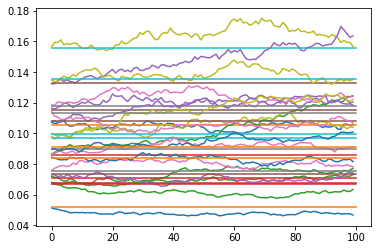

In [251]:
for i in range(20):
    with numpyro.handlers.seed(rng_seed=i):
        k = 10

        beta0 = numpyro.sample('beta', dist.Gamma(k, k * 10))
        beta0_inv = np.log(beta)

        d = dist.TransformedDistribution(
            dist.GaussianRandomWalk(scale=0.01, num_steps=100),
            dist.transforms.ExpTransform()
        )
        x = numpyro.sample('x', d)

        beta = beta0 * x

    plt.plot(beta)
    plt.plot([0, 100], [beta0, beta0])

    

plt.show()

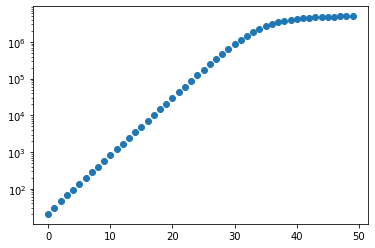

In [210]:
T = 50
y = np.cumsum(post_pred_samples['y'][:,:T], axis=1)
plt.plot(y.mean(axis=0), 'o')
plt.yscale('log')

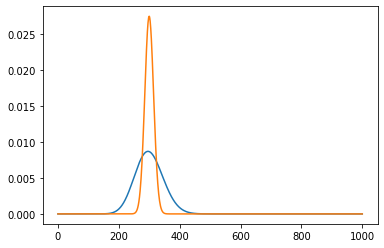

In [162]:
n = 1000
p = 0.3
conc = 100
d1 = dist.TransformedDistribution(
    dist.Beta(conc*p, conc*(1-p)),
    dist.transforms.AffineTransform(0, scale=n)
)
d2 = dist.Binomial(n, p)
x = np.arange(n+1, dtype='float32')
plt.plot(x, np.exp(d1.log_prob(x)))
plt.plot(x, np.exp(d2.log_prob(x)))

In [ ]:
for i in range(10):
    with numpyro.handlers.seed(rng_seed=i):
        
        T = 20
        
        x = numpyro.sample('x', dist.Normal(0, 1))
        rw = dist.GaussianRandomWalk(scale=1, num_steps=T)
        
        
        
    plt.plot(beta)
    plt.plot([0, 100], [beta0, beta0])